In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import _BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [3]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [16]:
def connectpoints( cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1, ls='k-'):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax is None:
        plt.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)
    else:
        ax.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)

def scatter_prevCents_wLine(
    self,
    ax,
    x_mol_loc,
    y_mol_loc,
    est_locs,
    ):
    
    if est_locs == 'gauss':
        x_plot, y_plot = np.array([
            [-6.22089389e-03, -8.63537702e-03, -7.08199489e-03,
             1.16123924e+01,  4.71539930e+01,  4.11468454e+01,
             1.77480571e+01,  1.99144744e+01,  3.55691643e+01,
             6.95110190e+01,  7.42965021e+01,  4.64090774e+01,
             5.28007441e+01,  7.44292784e+01,  1.00538531e+02,
             1.03607364e+02,  1.00677361e+02,  1.07459584e+02,
             1.23641313e+02,  1.34208757e+02,  1.32841372e+02],
           [ 2.57522552e+01,  1.41904273e+02,  1.59118114e+02,
             2.60339271e+01,  1.19457787e+02,  1.54363633e+02,
            -7.82381116e-03,  1.05647901e+01,  3.57362110e+01,
             9.93872897e+01,  1.45886978e+02, -2.28427405e-03,
             1.80574413e+01,  5.01486941e+01,  1.00611760e+02,
             1.39989021e+02,  1.81483775e-02,  2.77313771e+01,
             6.33763522e+01,  1.02807181e+02,  1.36433965e+02]])

    elif est_locs == 'model':
        x_plot, y_plot = np.array([
            [-3.79446016e-01,  6.31216977e+01,  7.24790158e-03],
            [ 1.58114838e-02,  1.09134497e+02,  4.24982069e-04],
            [-2.75243763e-03,  1.34130023e+02,  5.26723937e-04],
            [ 2.93192884e+01,  6.62682416e+01,  7.88541558e-02],
            [ 3.29342190e+01,  1.01792303e+02,  5.41232827e-02],
            [ 3.24200002e+01,  1.32723982e+02,  4.67618907e-03],
            [ 7.07803978e+01,  8.44672663e-02,  4.41251938e-03],
            [ 6.67919367e+01,  3.50785899e+01,  9.27508516e-02],
            [ 6.07286290e+01,  6.51238565e+01,  5.66137521e-03],
            [ 6.29237656e+01,  9.87222261e+01,  2.70297403e-02],
            [ 6.34351084e+01,  1.30504289e+02,  2.76476680e-03],
            [ 9.66093292e+01,  1.81623336e-02,  1.07848640e-03],
            [ 9.57527456e+01,  3.31659123e+01,  8.46334790e-03],
            [ 9.41546488e+01,  6.58348011e+01,  1.93248140e-04],
            [ 9.50474161e+01,  9.84121141e+01,  9.28629166e-03],
            [ 9.39398866e+01,  1.29099740e+02,  1.63610087e-02],
            [ 1.29120191e+02,  1.13037440e-02,  8.43924948e-04],
            [ 1.28989330e+02,  3.32884470e+01,  1.23312103e-02],
            [ 1.28735105e+02,  6.60453871e+01,  2.33522767e-02],
            [ 1.27932606e+02,  9.79643783e+01,  2.97773787e-02],
            [ 1.25486508e+02,  1.28302159e+02,  1.87797406e-02]])[:,:2].T
    
    for i in np.arange(x_plot.shape[0]):
        connectpoints(
            cen_x=x_plot,
            cen_y=y_plot,
            mol_x=x_mol_loc,
            mol_y=y_mol_loc,
            p=i,
            ax=ax,
            zorder=1,
            ls='k--'
            )
    localization_handle = ax.scatter(
        x_plot,
        y_plot,
        s=10,
        alpha=.5,
#         c=['C2'],
        zorder=2,
        facecolors='none', edgecolors='C4' 
        )
    return ax

starting Matlab...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields

 initial guess for molecule 0 location: (-0.04439835115315252,20.

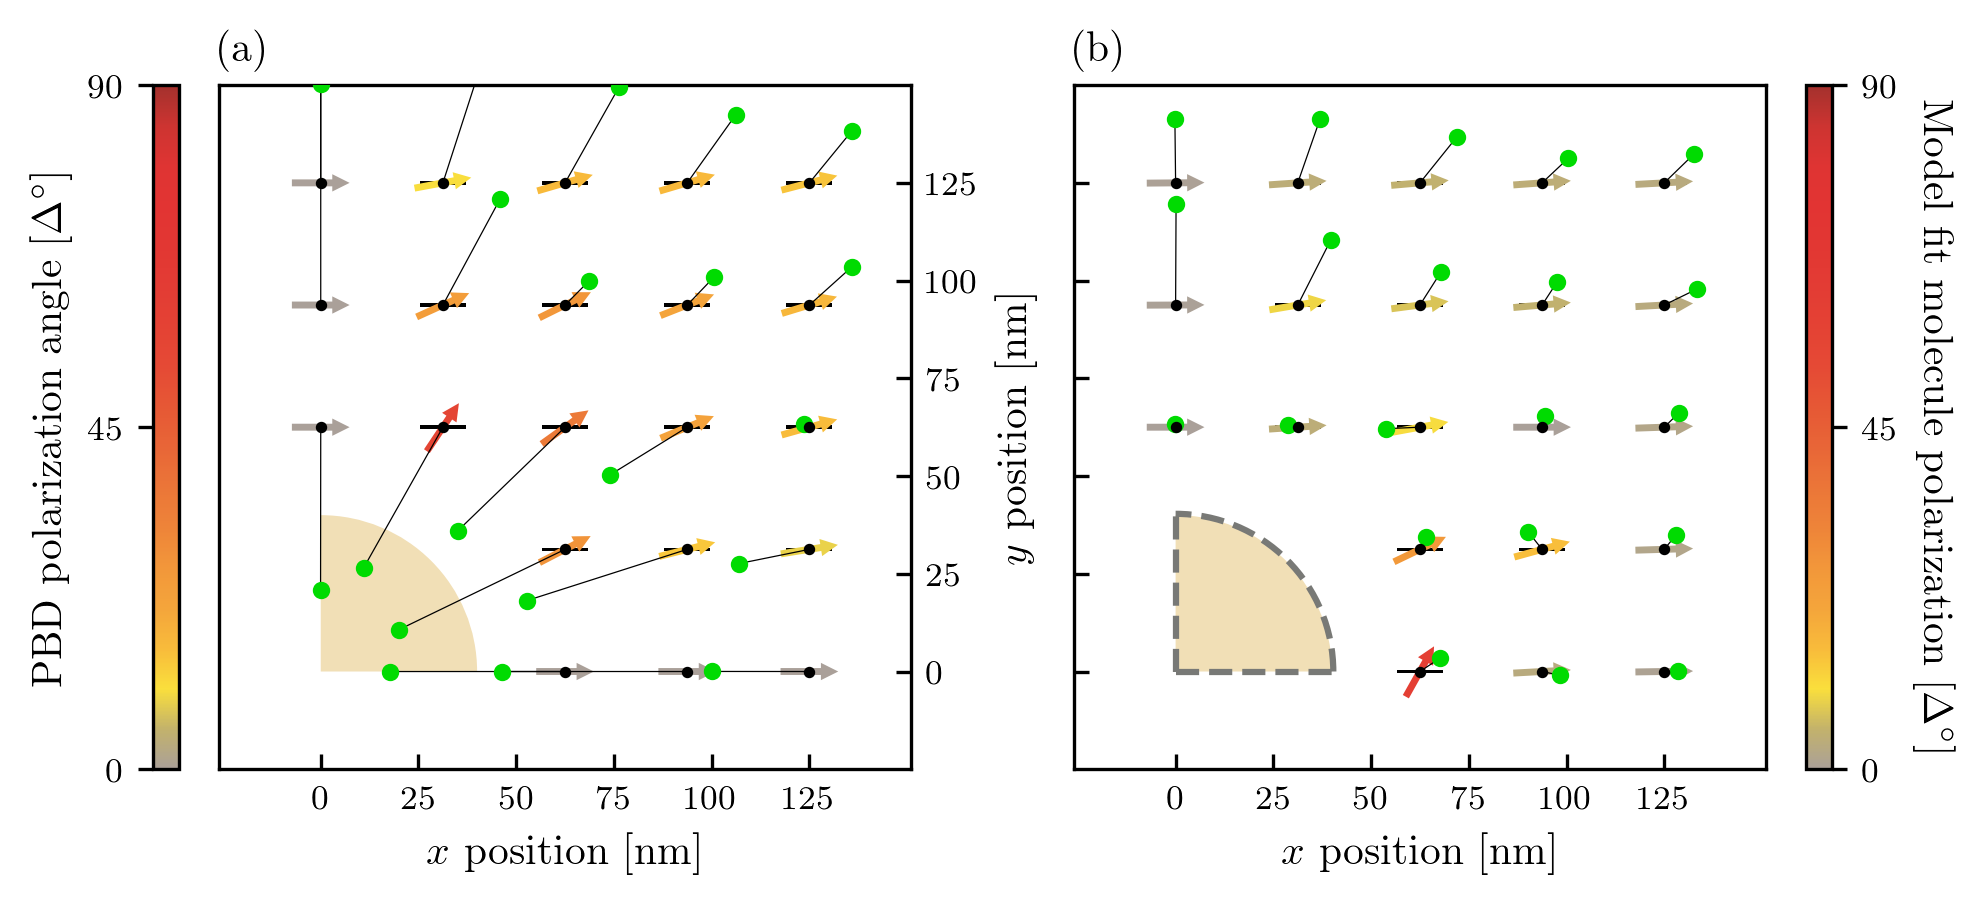

In [12]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_NApt92',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

## Perform image fits
fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_NApt92'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# fit_inst.plot_fit_results_as_quiver_map(sim_inst)   
fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

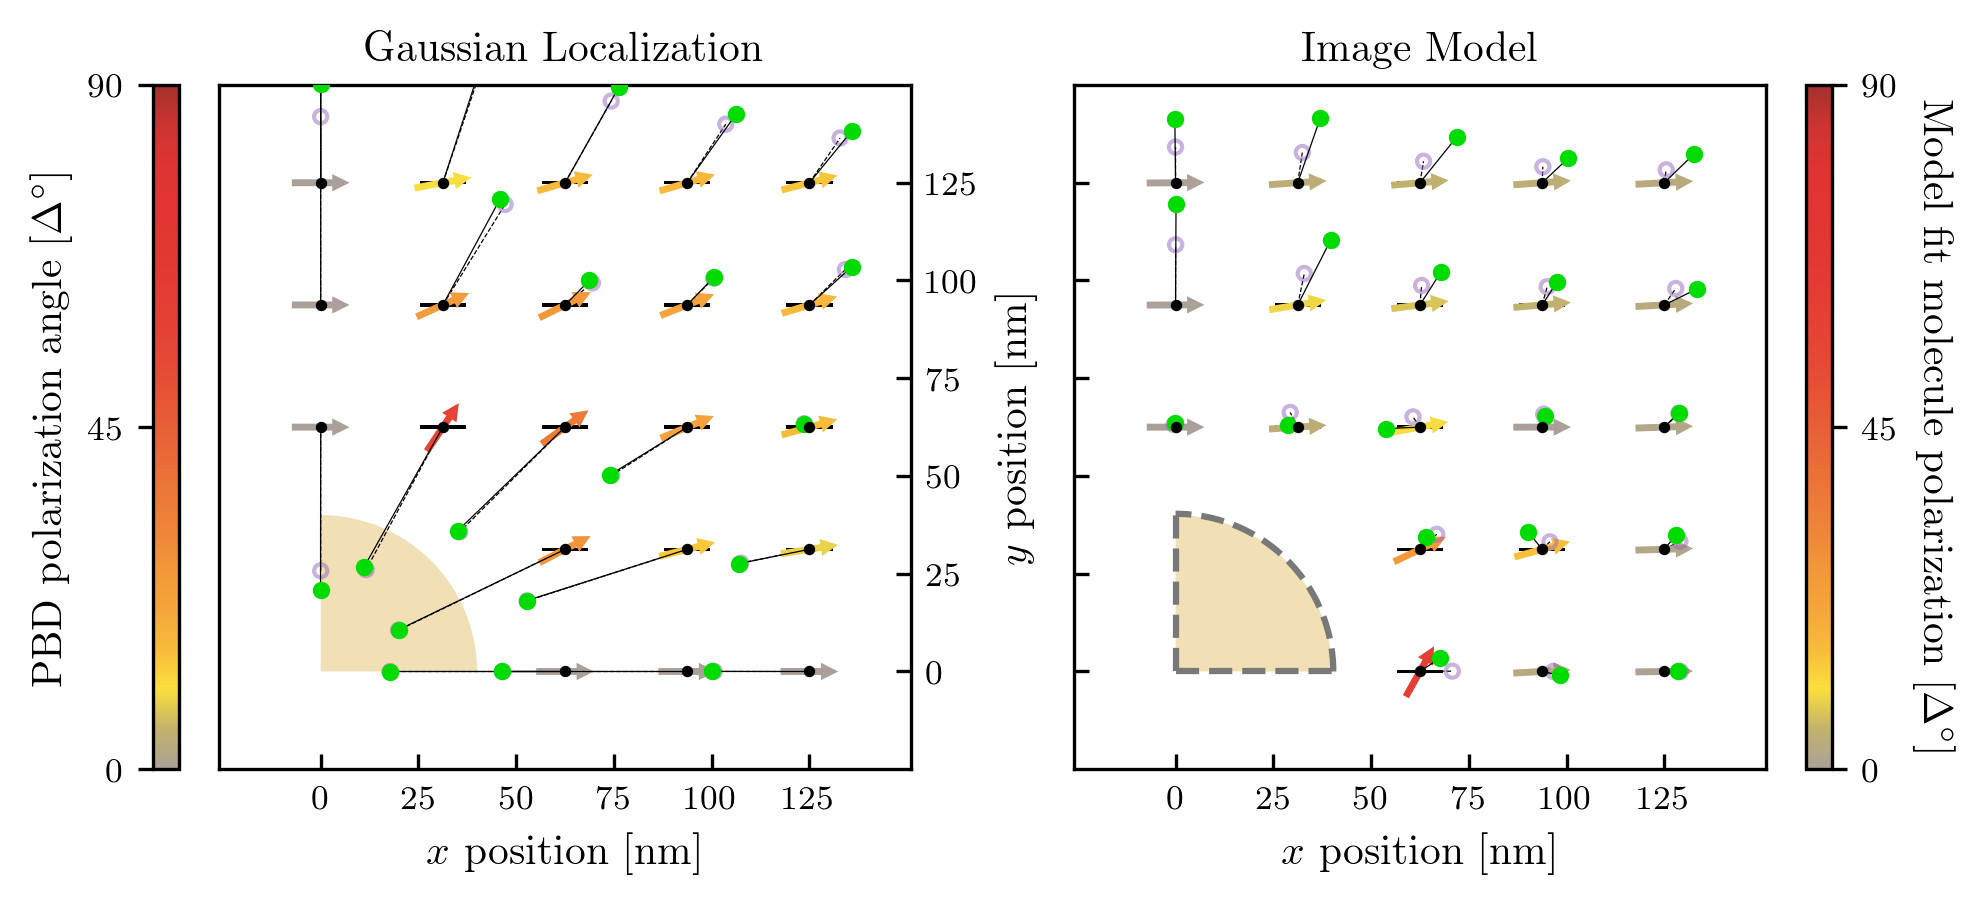

In [17]:
axs, fig5_ms = bem.fig5(
    sim_inst, 
    fit_inst, 
    draw_quadrant=True, 
    show_ax_labels=True,
#     show_legend=True
    )

scatter_prevCents_wLine(
    fit_inst,
    axs[1],
    sim_inst.mol_locations[:,0],
    sim_inst.mol_locations[:,1],
    est_locs='gauss'
    )

scatter_prevCents_wLine(
    fit_inst,
    axs[2],
    sim_inst.mol_locations[:,0],
    sim_inst.mol_locations[:,1],
    est_locs='model'
    )

# loc_map_legend(axs[2], loc_label='fit localization')
# fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [19]:
180*np.arcsin(.92)/np.pi

66.92608193436904

starting Matlab...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields

 initial guess for molecule 0 location: (-12.543401912910333,8.83

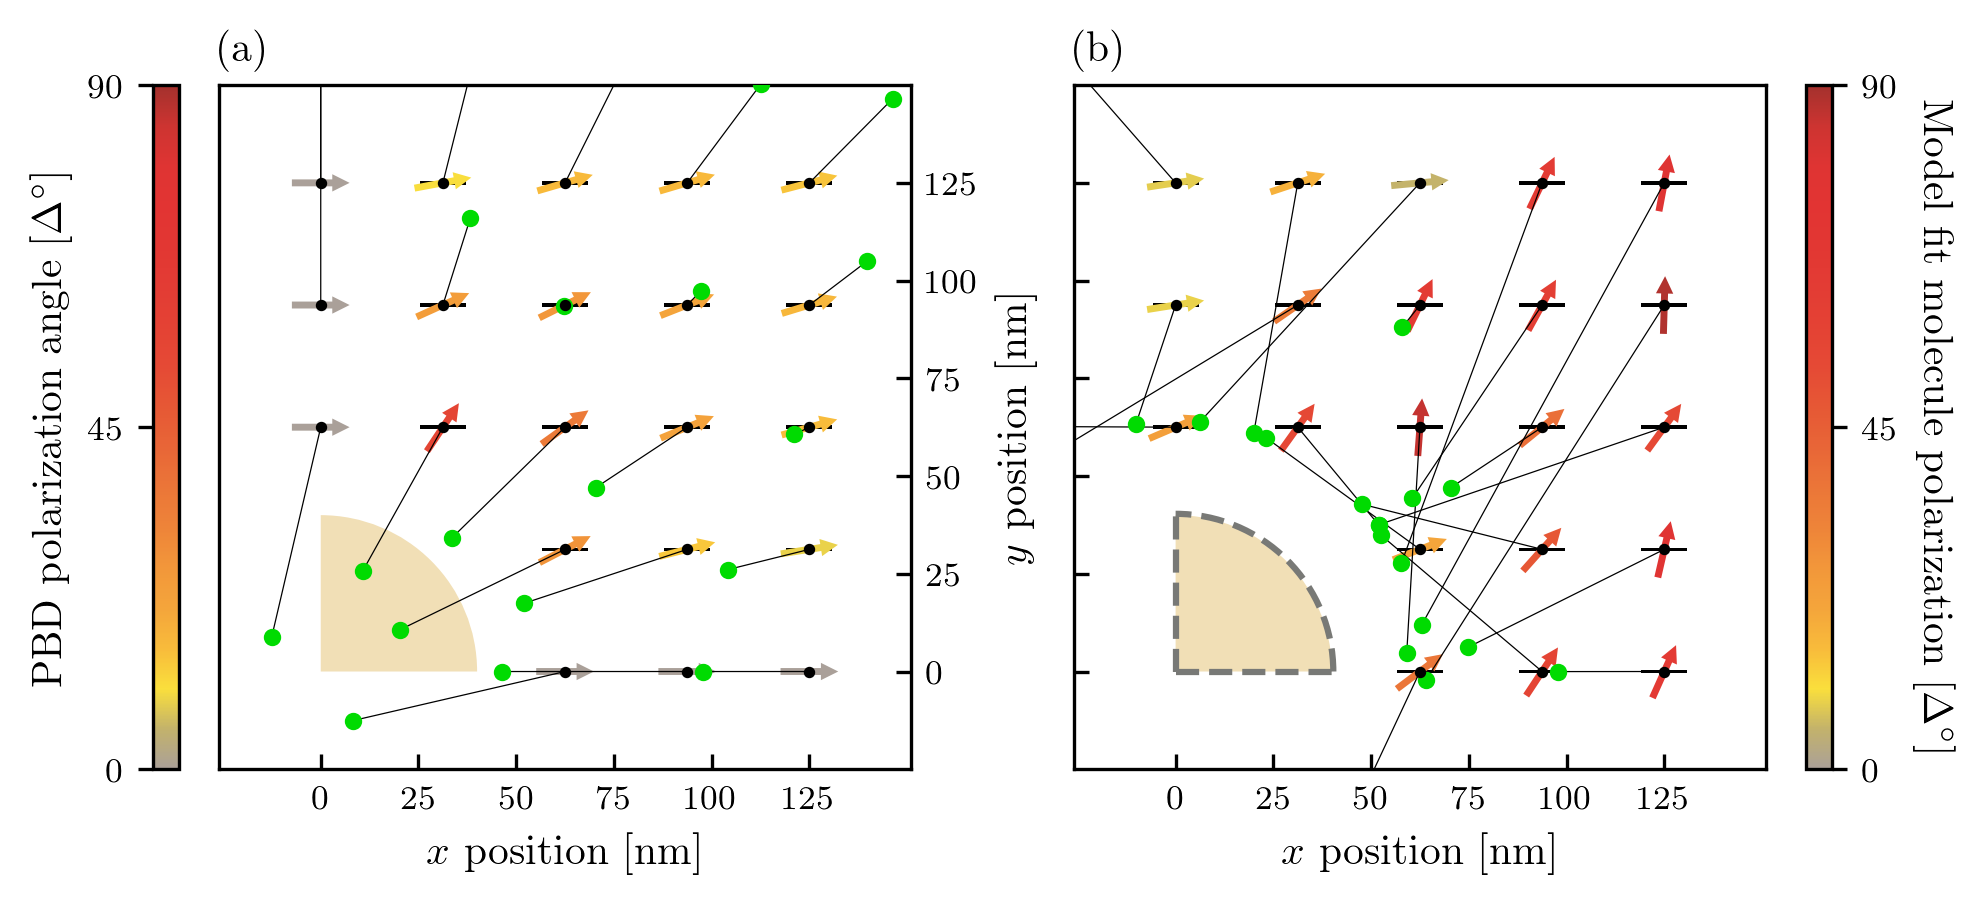

In [5]:

sim_inst_NApt1 = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmDrude_NApt1',
    simulation_file_name='SphereDrude_NoSub_dipDrive_E')
sim_inst_NApt1.trial_images = sim_inst_NApt1.calculate_BEM_fields()

## Perform image fits
fit_inst_NApt1 = fit.FitModelToData(
    sim_inst_NApt1.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmDrude_NApt1'
    )
fit_inst_NApt1.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
# fit_inst_NApt1.plot_fit_results_as_quiver_map(sim_inst_NApt1)   
fig5 = bem.fig5(sim_inst_NApt1, fit_inst_NApt1, draw_quadrant=True)